In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [4]:
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from numba import njit, prange

In [55]:
from analysis_routines import * 
from harmonic_analysis import *
from utide import solve
from plotting_routines_xr import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [6]:
data = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')

In [7]:
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')

In [8]:
em_ci = np.load(data_dir / 'SHDR_fit/aux/AGL_20181116_ci_fit_real_em.npy')
mld_thresh_i_02 = np.load(data_dir / 'SHDR_fit/aux/02_threshold_i_20181116.npy')

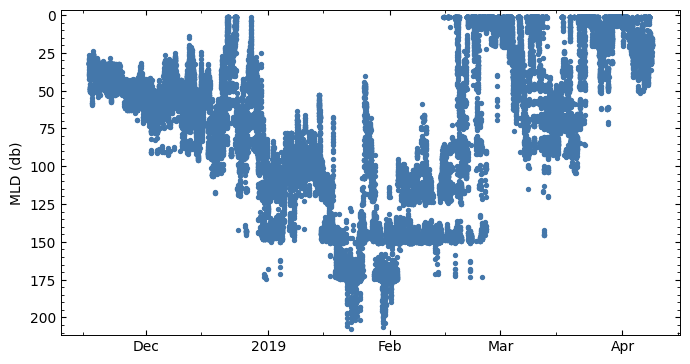

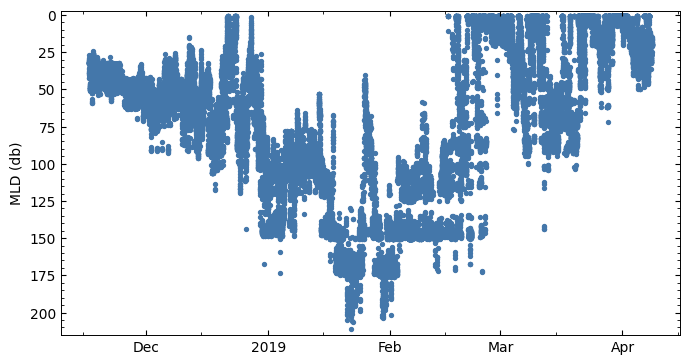

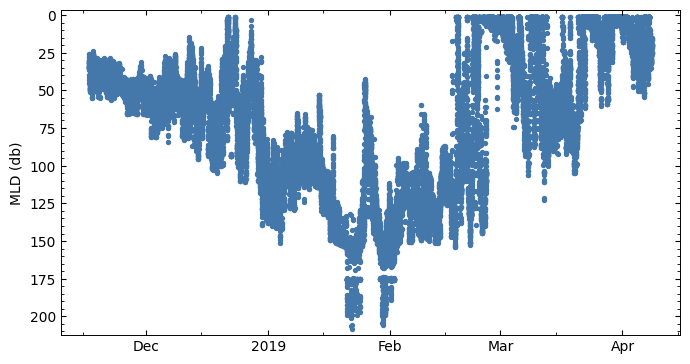

In [51]:
plot_fit_variable(df_s, 'D1', period=[None, None, 60])
plot_fit_variable(df_c, 'D1', period=[None, None, 60])
plot_fit_variable(df_ci, 'D1', period=[None, None, 60])

### Distance


In [52]:
locs_5_s, ratio_5_s = distance(df_s, 'D1', 1, 5)
locs_10_s, ratio_10_s = distance(df_s, 'D1', 1, 10)
locs_15_s, ratio_15_s = distance(df_s, 'D1', 1, 15)
locs_5_c, ratio_5_c = distance(df_c, 'D1', 1, 5)
locs_10_c, ratio_10_c = distance(df_c, 'D1', 1, 10)
locs_15_c, ratio_15_c = distance(df_c, 'D1', 1, 15)
locs_5_ci, ratio_5_ci = distance(df_ci, 'D1', 1, 5)
locs_10_ci, ratio_10_ci = distance(df_ci, 'D1', 1, 10)
locs_15_ci, ratio_15_ci = distance(df_ci, 'D1', 1, 15)

ratios_5 = np.array([ratio_5_s, ratio_5_c, ratio_5_ci])*100
ratios_10 = np.array([ratio_10_s, ratio_10_c, ratio_10_ci])*100
ratios_15 = np.array([ratio_15_s, ratio_15_c, ratio_15_ci])*100

In [53]:
D1_s = df_s['D1'].to_numpy()
D1_c = df_c['D1'].to_numpy()
D1_ci = df_ci['D1'].to_numpy()

distances_10_s = D1_s[locs_10_s + 1] - D1_s[locs_10_s]
date_s = data.date[locs_10_s]

distances_10_c = D1_c[locs_10_c + 1] - D1_c[locs_10_c]
date_c = data.date[locs_10_c]

distances_10_ci = D1_ci[locs_10_ci + 1] - D1_ci[locs_10_ci]
date_ci = data.date[locs_10_ci]

def plot_distances(df, variable, locs=None, period=[None, None]):
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=None)
    formatter = mdates.ConciseDateFormatter(locator)
    minor_locator = mdates.AutoDateLocator(minticks=6)
    
    i_0 = np.searchsorted(locs, lims[0])
    i_f = np.searchsorted(locs, lims[1])
    locs = locs[i_0:i_f]
    arr_variable = df[variable].to_numpy()
    
    
    distances = arr_variable[locs + 1] - arr_variable[locs] 
    date_d = df['date'].to_numpy()[locs]
    
    fig, ax = plt.subplots(figsize=(7, 3.75))
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_minor_locator(locator)

    ax.scatter(date_d, distances)
    fig.tight_layout()
    plt.show()
    return distances

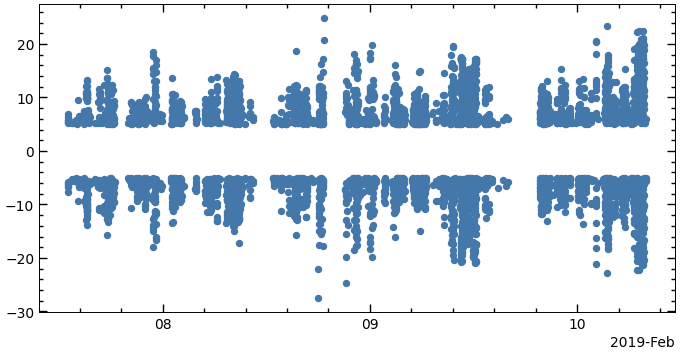

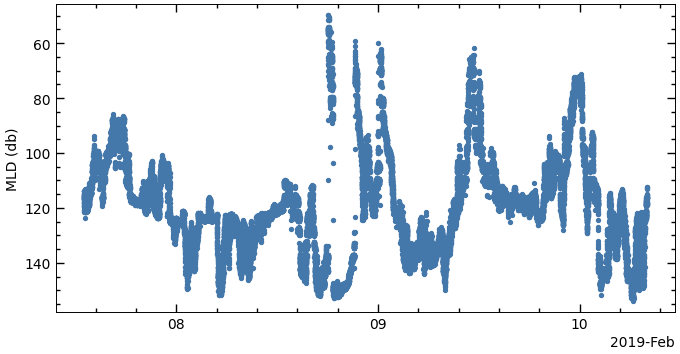

In [175]:
date_0 = datetime(2019, 2, 7, 13)
date_1 = datetime(2019, 2, 10, 8)
plot_distances(df_ci, 'D1', locs_5_ci, lims=[date_0, date_1])
#density_plot(date_ci, np.abs(distances_ci), lims=[date_0, date_1])    
plot_fit_variable(df_ci, 'D1', lims=[date_0, date_1])

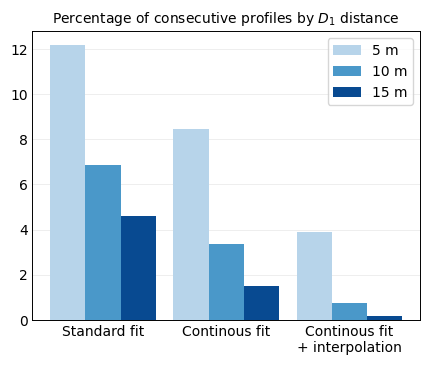

In [18]:
fig, ax = plt.subplots()
x = np.array([0, 1.4, 2.8])
bar_width = 0.4
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
b1 = ax.bar(x, ratios_5, width=bar_width, label='5 m', color=colors[0])
b2 = ax.bar(x + bar_width, ratios_10, width=bar_width, label='10 m', color=colors[1])
b3 = ax.bar(x + bar_width*2, ratios_15, width=bar_width, label='15 m', color=colors[2])
ax.tick_params(which='both', bottom=False, left=False, right=False, top=False)
ax.set_axisbelow(True)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.legend()
ax.set_title('Percentage of consecutive profiles by $D_1$ distance')
plt.show()

In [101]:
em_smaller_ci = np.where(em_ci < df_s['em'])[0]
isolated_locs_15_s = locs_15_s[1:][(locs_15_s[1:] - locs_15_s[:-1] != 1)]
print('Porcentaje de perfiles que difieren en más de 15 metros consecutivamente {:.1f}'.format(
    len(isolated_locs_15_s)/len(locs_15_s)*100))

distance_smaller_ci = locs_15_s[(np.in1d(locs_15_s, locs_15_ci) == False)]
distance_smaller_and_em_smaller = np.where(np.in1d(em_smaller_ci, distance_smaller_ci) == True)[0]

print('Porcentaje de perfiles ajustados c+i que disminuyen la distancia entre perfiles {:.2f}'.format(
    len(distance_smaller_and_em_smaller)/len(em_smaller_ci)))

em_s = df_s['em'].to_numpy()
em_jumps_s = np.where(em_s[1:] - em_s[:-1] > em_s.std())[0]
ratio_em_jumps_s_better_ci = len(np.where(np.in1d(em_jumps_s+1, em_smaller_ci) == True)[0])/len(em_jumps_s)
print(ratio_em_jumps_s_better_ci)


Porcentaje de perfiles que difieren en más de 15 metros consecutivamente 51.0
Porcentaje de perfiles ajustados c+i que disminuyen la distancia entre perfiles 0.29
0.5810348439354793


In [150]:
def compare_fit_modes_profile(df_s, df_c, df_ci, data, date_i, xlim=None):
    if isinstance(date_i, (int, np.integer)):
        data_i = data.isel(date=date_i)
        fit_s = df_s.iloc[date_i]
        fit_c = df_c.iloc[date_i]
        fit_ci = df_ci.iloc[date_i]
        
    else:
        data_i = data.sel(date=date_i)
        fit_s = df_s.loc[date_i]
        fit_c = df_c.loc[date_i]
        fit_ci = df_ci.loc[date_i]
    
    
    pres_i = data_i.meassured_depth
    temp_i = data_i.temp
    date_i_str = np.datetime_as_string(data_i.date, unit='s')

    pres_i = pres_i[np.isfinite(temp_i)]
    temp_i = temp_i[np.isfinite(temp_i)]

    zz = np.linspace(1, pres_i[-1] + 5, 300)

    fig, ax = plt.subplots(figsize=(4, 4.6875))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    ax.scatter(temp_i, pres_i, marker='o', fc='None', ec=colors[1], s=24)
    ax.set_ylim(pres_i[-1] + 10, 0)

    if xlim is None:
        ax.set_xlim(11, 16)
    
    else:
        ax.set_xlim(*xlim)

    ax.plot(fit_function(zz, df_s, date_i), zz, lw=1, c=colors[2], label='s')
    ax.plot(fit_function(zz, df_c, date_i), zz, lw=1, c=colors[0], label='c')
    ax.plot(fit_function(zz, df_ci, date_i), zz, lw=1, c=colors[1], label='ci')
    
    ax.axhline(fit_s.D1, ls='--', c=colors[2])
    ax.axhline(fit_c.D1, ls='--', c=colors[0])
    ax.axhline(fit_ci.D1, ls='--', c=colors[1])

    
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (db)')
    ax.set_title(date_i_str)
    ax.legend()
    fig.tight_layout()
    plt.show()

        
        
    
    
    
    

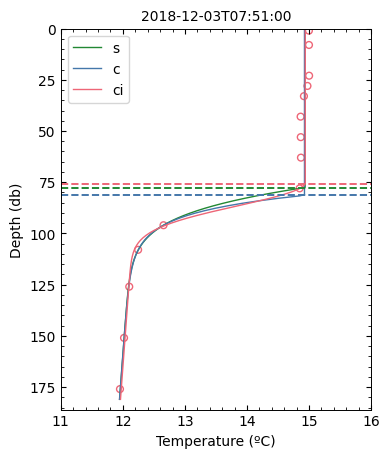

In [161]:
a = np.random.randint(0, len(df_s) - 1)
compare_fit_modes_profile(df_s, df_c, df_ci, data, a)

In [141]:
em_dif_large_s = distance(df_s, 'em', 1, 0.04)[0]
em_bigger_ci = np.where(em_ci - df_s['em'] > em_ci.std())[0]

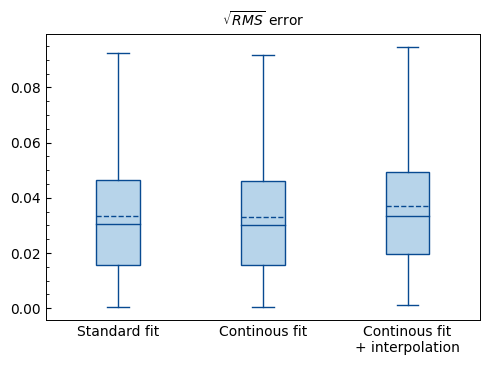

In [20]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['em'], df_c['em'], em_ci], showfliers=False, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$\sqrt{RMS}$ error')
fig.tight_layout()
plt.show()

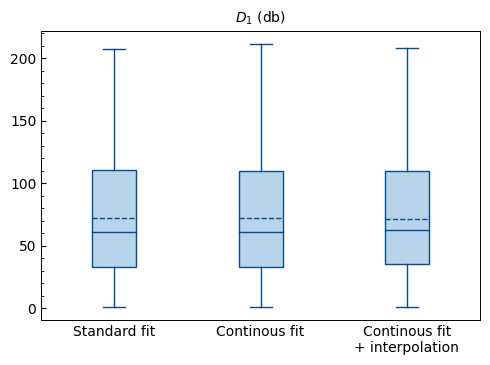

In [14]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['D1'], df_c['D1'], df_ci['D1']], showfliers=True, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$D_1$ (db)')
fig.tight_layout()
plt.show()

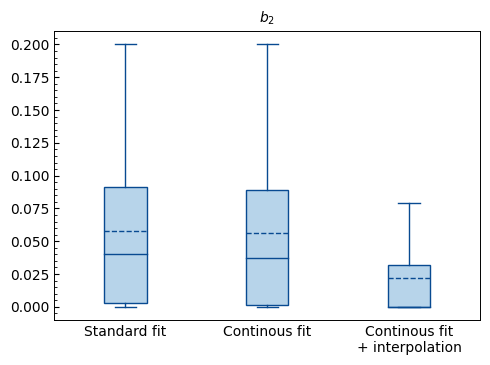

In [163]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['b2'], df_c['b2'], df_ci['b2']], showfliers=False, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$b_2$')
fig.tight_layout()
plt.show()

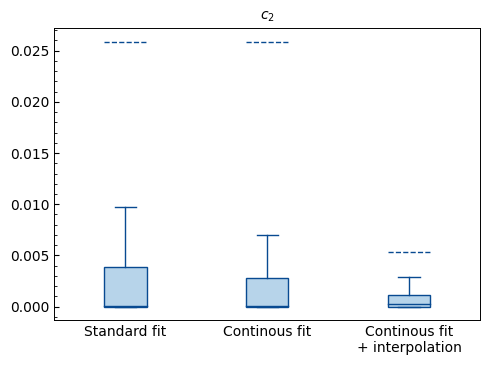

In [167]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['c2'], df_c['c2'], df_ci['c2']], showfliers=False, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$c_2$')
fig.tight_layout()
plt.show()

In [177]:
QI_ci = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_ci_20181116.npy')
QI_ci_i = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_ci_i_20181116.npy')
QI_c = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_c_20181116.npy')
QI_s = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_s_20181116.npy')
QI_s_i = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_s_i_20181116.npy')


0.8745855373564131
0.8781039186843932
0.8825600627586061
0.8826279261417992
nan


/tmp/ipykernel_17703/40009313.py:5: RuntimeWarning: Mean of empty slice
  print(np.nanmean(QI_s_i[:1000000]))


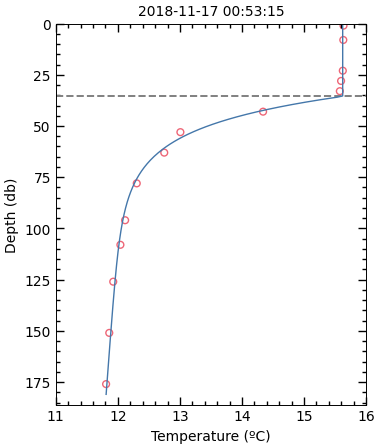

In [178]:
print(np.nanmean(QI_ci[:1000000]))
print(np.nanmean(QI_ci_i[:1000000]))
print(np.nanmean(QI_c[:1000000]))
print(np.nanmean(QI_s[:1000000]))
print(np.nanmean(QI_s_i[:1000000]))


plot_profile_fit(df_ci, temp, pres, 9999)

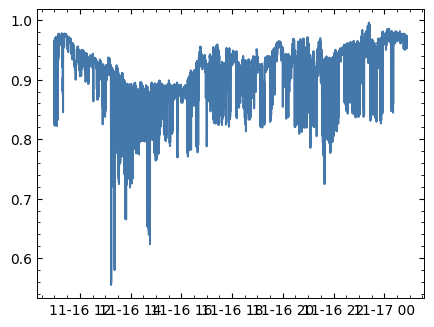

In [14]:
plt.plot(date[:10000], QI_s_i[:10000])